# Using synthetic data, test different Spatial Disaggregation methods

### QPSD1
- use the model future quantile to look up that quantile's in coarse and fine ERA-5 cdfs. Adjustment factor is the difference in temp/precip value between coarse and fine ERA-5 at the model future quantile. 

### QPSD2
- use the model future quantile to look up the coarse resolution ERA-5 *temperature/precip* value at that quantile. Use that temp/precip value to look up the fine resolution quantile which corresponds to the coarse resolution value. Look up the temp/precip value in the coarse ERA-5 CDF at the fine quantile. Adjustment factor is the difference in temp/precip value between the coarse and fine ERA-5 quantile at the fine resolution quantile. 

Note: this explicitly _doesn't_ preserve quantiles. 

### "Analog" 
- use the coarse resolution future quantile to look up the *day* on which that quantile occurred in the coarse ERA-5 cdf. Look up that same day in the fine resolution ERA-5. Adjustment factor is the fine - coarse temp/precip *on that day*

Note: this is essentially an analog-inspired method that accomplishes the method goal of QPSD2. 

Apr - May 2021. Started by K. McCusker, built out by D. Gergel. 



In [5]:
# ! pip install xclim

In [1]:
%matplotlib inline
import xarray as xr
import scipy as sp
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os 



In [2]:
write_direc = 'home/jovyan/downscaling/figures/' #'/gcs/rhg-data/climate/downscaled/workdir'

In [6]:
import xclim
from xclim import sdba


## QDM 


In [7]:
from scipy.stats import scoreatpercentile
from scipy.stats.kde import gaussian_kde

from xclim.testing.tests.test_sdba import utils as tu


## Synth data with `kind="+"` instead of "*"

Now we will test additive variables and other things

copied and adapted functions from ....`xclim/xclim/testing/tests/test_sdba/utils.py` 

#### Note
The following analyses and validation test on a single grid cell. 



In [8]:
# these funcs modified from ~/xclim/xclim/testing/tests/test_sdba/utils.py

# TODO add these funcs to a utils script or something, since they are now in two notebooks: synthetic_test_xclim_qdm.ipynb and this one
def my_series(values, name, start="2000-01-01"):
    import collections

    
    coords = collections.OrderedDict()
    for dim, n in zip(("time", "lon", "lat"), values.shape):
        if dim == "time":
            coords[dim] = pd.date_range(start, periods=n, freq=pd.DateOffset(days=1))
        else:
            coords[dim] = xr.IndexVariable(dim, np.arange(n))

    if name == "tas":
        attrs = {
            "standard_name": "air_temperature",
            "cell_methods": "time: mean within days",
            "units": "K",
            "kind": "+",
        }
    elif name == "pr":
        attrs = {
            "standard_name": "precipitation_flux",
            "cell_methods": "time: sum over day",
            "units": "kg m-2 s-1",
            "kind": "*",
        }

    return xr.DataArray(
        values,
        coords=coords,
        dims=list(coords.keys()),
        name=name,
        attrs=attrs,
    )

def my_dist():
    from scipy.stats import norm

    # ref ~ gamma(k=4, theta=7.5)  mu: 30, sigma: 15
    ref = norm(4, scale=7.5)

    # hist ~ gamma(k=8.15, theta=3.68) mu: 30, sigma: 10.5
    hist = norm(8.15, scale=3.68)

    # sim ~ gamma(k=16, theta=2.63) mu: 42, sigma: 10.5
    sim = norm(16, scale=2.63)

    return ref, hist, sim

def my_dist2():
    from scipy.stats import norm

    # ref ~ gamma(k=4, theta=7.5)  mu: 30, sigma: 15
    ref = norm(5, scale=6)

    # hist ~ gamma(k=8.15, theta=3.68) mu: 30, sigma: 10.5
    hist = norm(9, scale=4)

    # sim ~ gamma(k=16, theta=2.63) mu: 42, sigma: 10.5
    sim = norm(18, scale=2)

    return ref, hist, sim

def my_rvs(n, iteration=1, kind='+', random=True):
    # Frozen distributions
    if kind=='*':
        return tu.cannon_2015_rvs(n, random=random)
    else:
        if iteration==1:
            fd = my_dist()
        else:
            fd = my_dist2()

        if random:
            r = [d.rvs(n) for d in fd]
        else:
            raise NotImplementedError
    #         u = equally_spaced_nodes(n, None)
    #         r = [d.ppf(u) for d in fd]

        return map(lambda x: my_series(x, "tas"), r)

def add_annual_cycle(ds):
    annual_cycle = np.sin(2 * np.pi * (ds.time.dt.dayofyear.values / 365.25 - 0.28)) 
    return (ds + 10*annual_cycle)

def add_simple_trend(ds, totalchange=20):
    trend = np.linspace(0,totalchange,len(ds.time))
    return ds + trend


    

In [9]:
random = True
# n = 10000
n = 620
nquantiles = 100
kind = "+" #"*" #"+"

if kind=='*':
    kindstr='mult'
else:
    kindstr='add'

ref, hist, sim = my_rvs(n, kind=kind, random=random)
ref2, hist2, sim2 = my_rvs(n, kind=kind, iteration=2, random=random)


Easier to test this without day grouping and so don't add a seasonal cycle

In [10]:
# add a simple future trend and annual cycle

# ref = add_annual_cycle(ref)
# hist = add_annual_cycle(hist)
# sim = add_annual_cycle(sim)

# ref2 = add_annual_cycle(ref2)
# hist2 = add_annual_cycle(hist2)
# sim2 = add_annual_cycle(sim2)

# sim2trend = add_simple_trend(sim2, totalchange=20)
# sim2trend = add_annual_cycle(sim2trend)

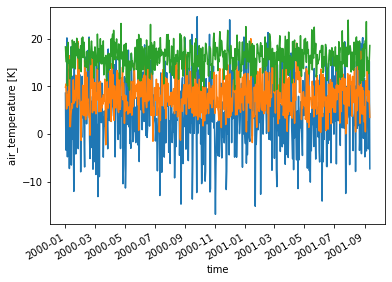

In [11]:
ref.plot()
hist.plot()
sim.plot()

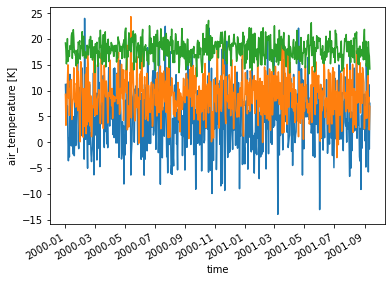

In [12]:
ref2.plot()
hist2.plot()
sim2.plot()

In [13]:
fine= xr.concat([ref, hist, ref2, hist2], dim=pd.Index([0,1,2,3],name='space'))
fine

<xarray.DataArray 'tas' (space: 4, time: 620)>
array([[ 8.57794152, -3.36243946,  3.46746474, ...,  0.30080625,
        15.24725476, -7.27793372],
       [ 9.79876217, 10.49066583,  5.25711238, ...,  9.08569092,
         6.48072928,  3.49310399],
       [11.19061202,  7.21085598, 11.26920332, ..., 11.17869506,
        -1.31429404,  7.54306589],
       [ 9.28919893,  3.29192153,  5.81623601, ...,  8.76151927,
         2.38495491,  6.93369935]])
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2001-09-11
  * space    (space) int64 0 1 2 3
Attributes:
    standard_name:  air_temperature
    cell_methods:   time: mean within days
    units:          K
    kind:           +

In [14]:
coarse = fine.mean(dim='space')
# coarse

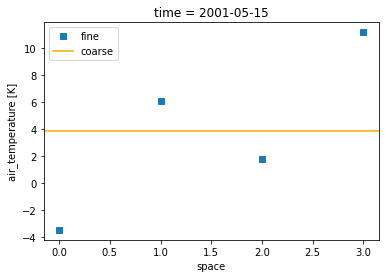

In [15]:
# look at one "grid cell" day

# onetime=3555
onetime = 500

fine.isel(time=onetime).plot(marker='s',label='fine',linestyle='none')
plt.axhline(coarse.isel(time=onetime),color='orange',label='coarse')
plt.legend()

In [16]:
# this is the future we want to downscale
csim = sim # coarse
csimf = xr.concat([csim, csim, csim, csim], dim=fine.space) #resample to fine res
csimf

<xarray.DataArray 'tas' (space: 4, time: 620)>
array([[18.27049111, 16.24614392, 15.06927032, ..., 12.6824865 ,
        15.84686272, 18.55266073],
       [18.27049111, 16.24614392, 15.06927032, ..., 12.6824865 ,
        15.84686272, 18.55266073],
       [18.27049111, 16.24614392, 15.06927032, ..., 12.6824865 ,
        15.84686272, 18.55266073],
       [18.27049111, 16.24614392, 15.06927032, ..., 12.6824865 ,
        15.84686272, 18.55266073]])
Coordinates:
  * space    (space) int64 0 1 2 3
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2001-09-11
Attributes:
    standard_name:  air_temperature
    cell_methods:   time: mean within days
    units:          K
    kind:           +

In [17]:
# _ = fine.quantile(np.linspace(0,1,100),dim='time').plot.line(x='quantile')
# _ = coarse.quantile(np.linspace(0,1,100),dim='time').plot.line(x='quantile',color='k',linewidth=2,linestyle='--')



In [18]:
# import statsmodels as sm
# import statsmodels.distributions
# from statsmodels.distributions.empirical_distribution import ECDF

# # https://stackoverflow.com/questions/3209362/how-to-plot-empirical-cdf-in-matplotlib-in-python

In [19]:
# coarsecdf = ECDF(coarse)

In [20]:
# plt.plot(coarsecdf.x,coarsecdf.y)

In [21]:
# fine.sel(space=1)

Text(0.5, 1.0, 'bias corrected future')

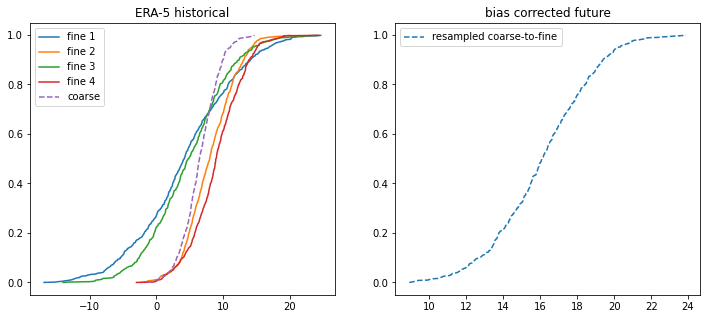

In [22]:
fig, axs = plt.subplots(1,2, figsize=(12, 5))
ax=axs[0]
# plot empirical cdfs
for spi in [0,1,2,3]:
    x = np.sort(fine.sel(space=spi))
    y = np.arange(len(x))/float(len(x))
    _ = ax.plot(x, y, label="fine {}".format(spi + 1))

x = np.sort(coarse)
y = np.arange(len(x))/float(len(x))
_ = ax.plot(x, y, linestyle="--", label="coarse")
ax.legend()
ax.set_title('ERA-5 historical')
# ax.set_xlim([-25, 25])


ax=axs[1]
'''for spi in [0,1,2,3]:
    x = np.sort(csimf.sel(space=spi))
    y = np.arange(len(x))/float(len(x))
    _ = ax.plot(x, y, label="fine {}".format(spi))'''

x = np.sort(csim)
y = np.arange(len(x))/float(len(x))
_ = ax.plot(x, y, linestyle="--", label="resampled coarse-to-fine")
ax.legend()
ax.set_title('bias corrected future')
# ax.set_xlim([-25, 25])

In [24]:
testq = .65

## QPSD1


'ax=axs[2]\nfor spi in [0,1,2,3]:\n    xf = np.sort(fine.sel(space=spi))\n    yf = np.arange(len(xf))/float(len(xf))\n    \n    xc = np.sort(coarse)\n    yc = np.arange(len(xc))/float(len(xc))\n    \n    af = xf - xc\n    \n    xsim = np.sort(csimf.sel(space=spi))\n    ysim = np.arange(len(xsim))/float(len(xsim))\n    \n    \n    _ = ax.plot(xsim + af, yc, label="downscaled {}".format(spi+1), alpha=.5)\n    \n_ = ax.plot(xsim, ysim, label="bias corrected", linewidth=2)\nax.legend()\nax.set_title(\'downscaled\')\nax.set_xlim([-25, 25])'

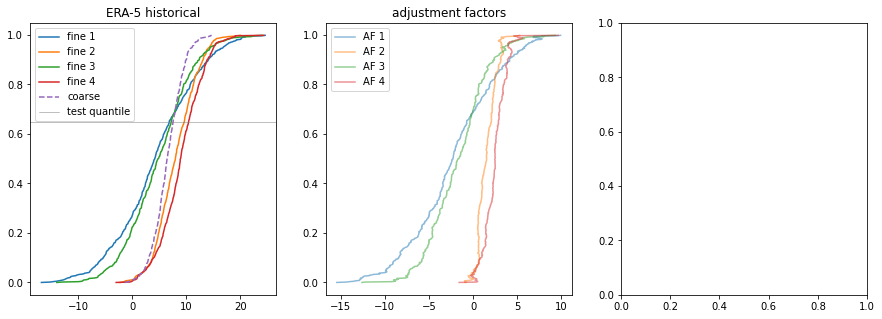

In [25]:
fig, axs = plt.subplots(1,3, figsize=(15, 5))
ax=axs[0]
# plot empirical cdfs
#   loop through space cells
dadt = []
for spi in [0,1,2,3]:
    x = np.sort(fine.sel(space=spi))
    y = np.arange(len(x))/float(len(x))
    _ = ax.plot(x, y, label="fine {}".format(spi+1))

    dadt.append(xr.DataArray([x,y],dims=('variable','cdf'), coords={'variable':['x','y']}))

finecdf = xr.concat(dadt, dim=fine.space)    

x = np.sort(coarse)
y = np.arange(len(x))/float(len(x))
_ = ax.plot(x, y, linestyle="--", label="coarse")
ax.axhline(y=testq, linewidth=.5, color='.5', label='test quantile')
ax.legend()
ax.set_title('ERA-5 historical')
# ax.set_xlim([-25, 25])

ax=axs[1]
for spi in [0,1,2,3]:
    xf = np.sort(fine.sel(space=spi))
    yf = np.arange(len(xf))/float(len(xf))
    
    xc = np.sort(coarse)
    yc = np.arange(len(xc))/float(len(xc))

    _ = ax.plot(xf-xc, yc, label="AF {}".format(spi+1), alpha=.5)

ax.legend()
ax.set_title('adjustment factors')
# ax.axvline(x=0, linewidth=.5, color='k')
# ax.set_xlim([-25, 25])

'''ax=axs[2]
for spi in [0,1,2,3]:
    xf = np.sort(fine.sel(space=spi))
    yf = np.arange(len(xf))/float(len(xf))
    
    xc = np.sort(coarse)
    yc = np.arange(len(xc))/float(len(xc))
    
    af = xf - xc
    
    xsim = np.sort(csimf.sel(space=spi))
    ysim = np.arange(len(xsim))/float(len(xsim))
    
    
    _ = ax.plot(xsim + af, yc, label="downscaled {}".format(spi+1), alpha=.5)
    
_ = ax.plot(xsim, ysim, label="bias corrected", linewidth=2)
ax.legend()
ax.set_title('downscaled')
ax.set_xlim([-25, 25])'''

the above shows that for any days that have a quantile greater than about 0.7, the fine resolution cells underlying it will all get added to. Thus if re-averaged, the coarse res will be much greater than it started out as! See below for an example of this in action.

In [26]:
# choose a day in the future sim and its inverse cdf to test

csimfinv = csimf.rank(dim='time', pct=True) # inverse cdf of coarse-to-fine time series

# pick one test time (e.g. one "grid cell day")
daytest = csimfinv.isel(time=onetime).sel(space=0) #choose one grid cell b/c they are all the same

print('quantile on test day is:       {}: '.format(daytest.values))
print('future bias corrected value on test day is:          {}'.format(csim.isel(time=onetime).values))
print('fine values at this quantile:  {}'.format(fine.quantile(daytest, dim='time').values))
print('coarse value at this quantile: {}'.format(coarse.quantile(daytest, dim='time').values))

dayaf = fine.quantile(daytest, dim='time') - coarse.quantile(daytest, dim='time')

print('adjustment factors for this day: {}'.format(dayaf.values))

quantile on test day is:       0.3096774193548387: 
future bias corrected value on test day is:          14.815924038044868
fine values at this quantile:  [0.90671837 5.95966174 1.7217256  7.17261065]
coarse value at this quantile: 5.2105127300086975
adjustment factors for this day: [-4.30379436  0.74914901 -3.48878713  1.96209792]


In [27]:
# apply the downscaling af's to the coarse sim data
fsim_oneday = csimf.isel(time=onetime) + dayaf
fsim_oneday

<xarray.DataArray 'tas' (space: 4)>
array([10.51212968, 15.56507305, 11.32713691, 16.77802195])
Coordinates:
  * space     (space) int64 0 1 2 3
    time      datetime64[ns] 2001-05-15
    quantile  float64 0.3097

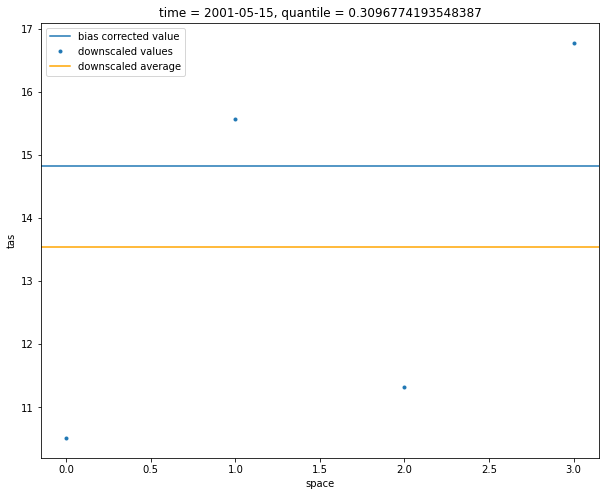

In [28]:
fig,ax = plt.subplots(1,1,figsize=(10,8))
ax.axhline(csim.isel(time=onetime), label="bias corrected value")
fsim_oneday.plot(ax=ax, marker='.',linestyle='none', label="downscaled values")
ax.axhline(fsim_oneday.mean(), color='orange', label="downscaled average")
ax.legend()

## QPSD2

In [29]:
def compute_tau_of(F_course, F_fine): 
    """
    function that implements QPSD2 downscaling method by computing tau_of indices that can be used to index into the coarse and fine CDFs 
    """
    tau_of_inds = []
    for x_oc_value in F_course:
        # np.argmin(np.abs(F_of.x - x_oc_tau_mp))
        tau_of_index = np.argmin(np.abs(F_fine - x_oc_value))
        tau_of_inds.append(tau_of_index)
    
    return tau_of_inds

test `compute_tau_of` function 

In [30]:
F_course = np.sort(coarse)
F_fine = np.sort(fine.sel(space=1))
tau_of_inds = compute_tau_of(F_course, F_fine)

Text(0.5, 1.0, 'adjustment factors')

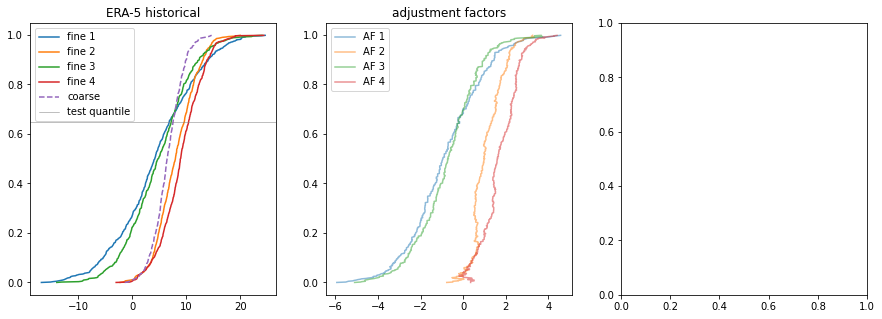

In [31]:
fig, axs = plt.subplots(1,3, figsize=(15, 5))
ax=axs[0]
# plot empirical cdfs
#   loop through space cells
dadt = []
for spi in [0,1,2,3]:
    x = np.sort(fine.sel(space=spi))
    y = np.arange(len(x))/float(len(x))
    _ = ax.plot(x, y, label="fine {}".format(spi+1))

    dadt.append(xr.DataArray([x,y],dims=('variable','cdf'), coords={'variable':['x','y']}))

finecdf = xr.concat(dadt, dim=fine.space)    

x = np.sort(coarse)
y = np.arange(len(x))/float(len(x))
_ = ax.plot(x, y, linestyle="--", label="coarse")
ax.axhline(y=testq, linewidth=.5, color='.5', label='test quantile')
ax.legend()
ax.set_title('ERA-5 historical')
# ax.set_xlim([-25, 25])

ax=axs[1]
for spi in [0,1,2,3]:
    xf = np.sort(fine.sel(space=spi))
    yf = np.arange(len(xf))/float(len(xf))
    
    xc = np.sort(coarse)
    yc = np.arange(len(xc))/float(len(xc))
    
    tau_of_inds = compute_tau_of(xc, xf)
    xc_tauof = xc[tau_of_inds]
    xf_tauof = xf[tau_of_inds]

    _ = ax.plot(xf_tauof - xc_tauof, yc, label="AF {}".format(spi+1), alpha=.5)

ax.legend()
ax.set_title('adjustment factors')
# ax.axvline(x=0, linewidth=.5, color='k')
# ax.set_xlim([-25, 25])

In [32]:
# choose a day in the future sim and its inverse cdf to test

csimfinv = csimf.rank(dim='time', pct=True) # inverse cdf of coarse-to-fine time series

# pick one test time (e.g. one "grid cell day")
daytest = csimfinv.isel(time=onetime).sel(space=0) #choose one grid cell b/c they are all the same

print('quantile on test day is:       {}: '.format(daytest.values))
print('future bias corrected value on test day is:          {}'.format(csim.isel(time=onetime).values))
print('fine values at this quantile:  {}'.format(fine.quantile(daytest, dim='time').values))
print('coarse value at this quantile: {}'.format(coarse.quantile(daytest, dim='time').values))

F_course = coarse.quantile(daytest, dim='time')
F_fine = fine.quantile(daytest, dim='time')

tau_of_inds1 = np.argmin(np.abs(np.sort(fine.sel(space=0)) - daytest.values))
tau_of_inds2 = np.argmin(np.abs(np.sort(fine.sel(space=1)) - daytest.values))
tau_of_inds3 = np.argmin(np.abs(np.sort(fine.sel(space=2)) - daytest.values))
tau_of_inds4 = np.argmin(np.abs(np.sort(fine.sel(space=3)) - daytest.values))

# dayaf = fine.quantile(daytest, dim='time') - coarse.quantile(daytest, dim='time')
dayaf1 = np.sort(fine.sel(space=0))[tau_of_inds1] - np.sort(coarse)[tau_of_inds1]
dayaf2 = np.sort(fine.sel(space=1))[tau_of_inds2] - np.sort(coarse)[tau_of_inds2]
dayaf3 = np.sort(fine.sel(space=2))[tau_of_inds3] - np.sort(coarse)[tau_of_inds3]
dayaf4 = np.sort(fine.sel(space=3))[tau_of_inds4] - np.sort(coarse)[tau_of_inds4]

print('adjustment factors for this day: {}'.format(dayaf.values))

quantile on test day is:       0.3096774193548387: 
future bias corrected value on test day is:          14.815924038044868
fine values at this quantile:  [0.90671837 5.95966174 1.7217256  7.17261065]
coarse value at this quantile: 5.2105127300086975
adjustment factors for this day: [-4.30379436  0.74914901 -3.48878713  1.96209792]


In [33]:
# apply the downscaling af's to the coarse sim data
fsim_oneday1 = csimf.isel(time=onetime).isel(space=0) + dayaf1
fsim_oneday2 = csimf.isel(time=onetime).isel(space=1) + dayaf2
fsim_oneday3 = csimf.isel(time=onetime).isel(space=2) + dayaf3
fsim_oneday4 = csimf.isel(time=onetime).isel(space=3) + dayaf4

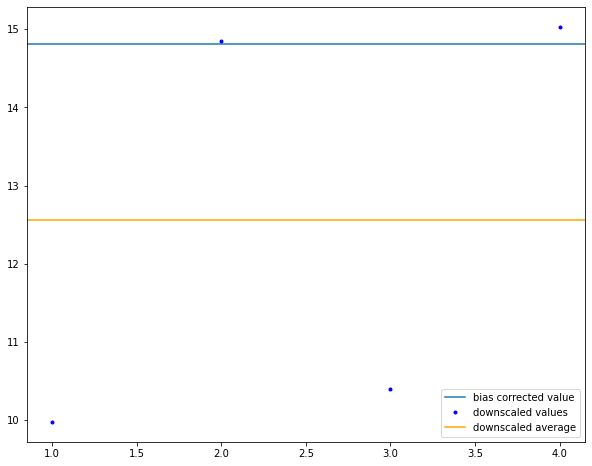

In [34]:
fig,ax = plt.subplots(1,1,figsize=(10,8))
ax.axhline(csim.isel(time=onetime), label="bias corrected value")

plt.plot(1, fsim_oneday1, marker='.',linestyle='none', color='blue')
plt.plot(2, fsim_oneday2, marker='.',linestyle='none', color='blue')
plt.plot(3, fsim_oneday3, marker='.',linestyle='none', color='blue')
plt.plot(4, fsim_oneday4, marker='.',linestyle='none', color='blue', label="downscaled values")

fsim_avg = (fsim_oneday1 + fsim_oneday2 + fsim_oneday3 + fsim_oneday4) / 4

ax.axhline(fsim_avg, color='orange', label="downscaled average")
ax.legend()

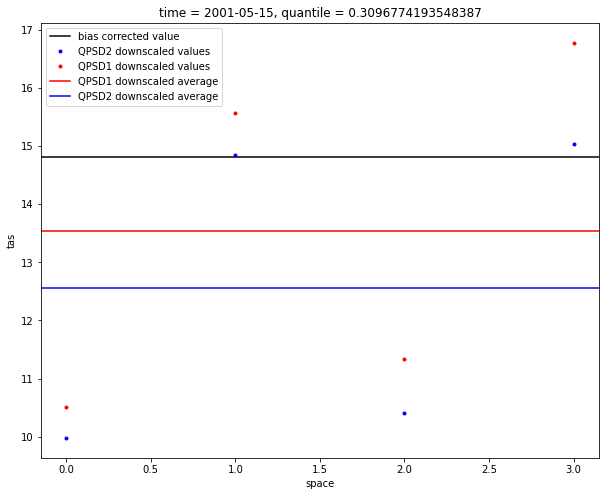

In [35]:
fig,ax = plt.subplots(1,1,figsize=(10,8))
ax.axhline(csim.isel(time=onetime), color='black', label="bias corrected value")

plt.plot(0, fsim_oneday1, marker='.',linestyle='none', color='blue')
plt.plot(1, fsim_oneday2, marker='.',linestyle='none', color='blue')
plt.plot(2, fsim_oneday3, marker='.',linestyle='none', color='blue')
plt.plot(3, fsim_oneday4, marker='.',linestyle='none', color='blue', label="QPSD2 downscaled values")

fsim_avg = (fsim_oneday1 + fsim_oneday2 + fsim_oneday3 + fsim_oneday4) / 4

fsim_oneday.plot(ax=ax, marker='.',linestyle='none', color='red', label="QPSD1 downscaled values")
ax.axhline(fsim_oneday.mean(), color='red', label="QPSD1 downscaled average")

ax.axhline(fsim_avg, color='blue', label="QPSD2 downscaled average")
ax.legend()

## Analog 

use the coarse resolution future quantile to look up the day on which that quantile occurred in the coarse ERA-5 cdf. Look up that same day in the fine resolution ERA-5. Adjustment factor is the fine - coarse temp/precip on that day

In [78]:
def compute_day_ind(coarse_quantiles, coarse): 
    """
    function that implements analog downscaling method by computing day indices that can be used to index into the coarse and fine CDFs 
    F_coarse: CDF of coarse res values 
    coarse: time series of coarse data 
    """
    day_inds = []
    for i, value in enumerate(coarse_quantiles):
        coarse_quantile_value = coarse.quantile(value, dim='time').values
        day_ind = np.argmin(np.abs(coarse.values - coarse_quantile_value))
        day_inds.append(day_ind)
    
    return day_inds

Text(0.5, 1.0, 'adjustment factors')

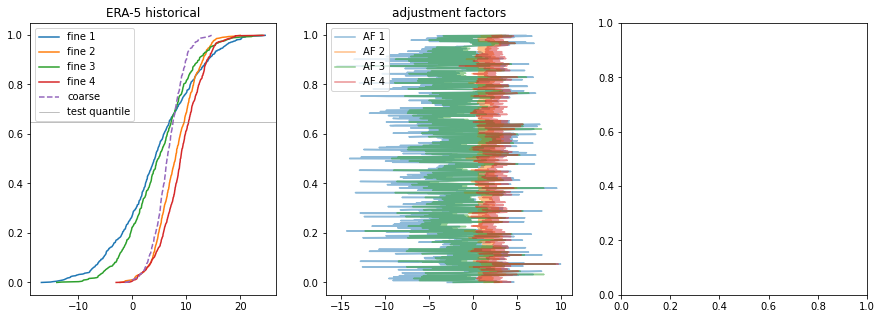

In [79]:
fig, axs = plt.subplots(1,3, figsize=(15, 5))
ax=axs[0]
# plot empirical cdfs
#   loop through space cells
dadt = []
for spi in [0,1,2,3]:
    x = np.sort(fine.sel(space=spi))
    y = np.arange(len(x))/float(len(x))
    _ = ax.plot(x, y, label="fine {}".format(spi+1))

    dadt.append(xr.DataArray([x,y],dims=('variable','cdf'), coords={'variable':['x','y']}))

finecdf = xr.concat(dadt, dim=fine.space)    

x = np.sort(coarse)
y = np.arange(len(x))/float(len(x))
_ = ax.plot(x, y, linestyle="--", label="coarse")
ax.axhline(y=testq, linewidth=.5, color='.5', label='test quantile')
ax.legend()
ax.set_title('ERA-5 historical')
# ax.set_xlim([-25, 25])

ax=axs[1]
xc = np.sort(coarse)
yc = np.arange(len(xc))/float(len(xc))
# day_inds = compute_day_ind(xc, coarse)
day_inds = compute_day_ind(yc, coarse)
for spi in [0,1,2,3]:
    xf = np.sort(fine.sel(space=spi))
    yf = np.arange(len(xf))/float(len(xf))
    
    yc = np.arange(len(xc))/float(len(xc))
    
    xc_days = xc[day_inds]
    xf_days = xf[day_inds]

    _ = ax.plot(xf_days - xc_days, yc, label="AF {}".format(spi+1), alpha=.5)

ax.legend()
ax.set_title('adjustment factors')

use the coarse resolution future quantile to look up the day on which that quantile occurred in the coarse ERA-5 cdf. Look up that same day in the fine resolution ERA-5. Adjustment factor is the fine - coarse temp/precip on that day

In [69]:
# choose a day in the future sim and its inverse cdf to test

# csimfinv = csimf.rank(dim='time', pct=True) # inverse cdf of coarse-to-fine time series

# pick one test time (e.g. one "grid cell day")
daytest = csimfinv.isel(time=onetime).sel(space=0) #choose one grid cell b/c they are all the same

print('quantile on test day is:       {}: '.format(daytest.values))
print('future bias corrected value on test day is:          {}'.format(csim.isel(time=onetime).values))
print('fine values at this quantile:  {}'.format(fine.quantile(daytest, dim='time').values))
print('coarse value at this quantile: {}'.format(coarse.quantile(daytest, dim='time').values))

# look up value that corresponds to test quantile in the coarse CDF
coarse_quantile_value = coarse.quantile(daytest, dim='time').values

# find closest day index on which that quantile value occurred 
day_ind = np.argmin(np.abs(coarse.values - coarse_quantile_value))
print('day index on test day is:       {} '.format(day_ind))

# extract that day value from coarse and then from fine 
coarse_day = coarse.values[day_ind]
dayaf1 = fine.sel(space=0).values[day_ind] - coarse_day
dayaf2 = fine.sel(space=1).values[day_ind] - coarse_day
dayaf3 = fine.sel(space=2).values[day_ind] - coarse_day
dayaf4 = fine.sel(space=3).values[day_ind] - coarse_day

print('adjustment factors for this day: {} {} {} {}'.format(dayaf1, dayaf2, dayaf3, dayaf4))

quantile on test day is:       0.3096774193548387: 
future bias corrected value on test day is:          14.815924038044868
fine values at this quantile:  [0.90671837 5.95966174 1.7217256  7.17261065]
coarse value at this quantile: 5.2105127300086975
day index on test day is:       356 
adjustment factors for this day: 1.429047415002909 -0.6499374939576308 -4.047642076865002 3.2685321558197247


In [70]:
# apply the downscaling af's to the coarse sim data
fsim_oneday11 = csimf.isel(time=onetime).isel(space=0) + dayaf1
fsim_oneday22 = csimf.isel(time=onetime).isel(space=1) + dayaf2
fsim_oneday33 = csimf.isel(time=onetime).isel(space=2) + dayaf3
fsim_oneday44 = csimf.isel(time=onetime).isel(space=3) + dayaf4

analog downscaled average for this day: 14.81592403804487
bias corrected average for this day: 14.815924038044868


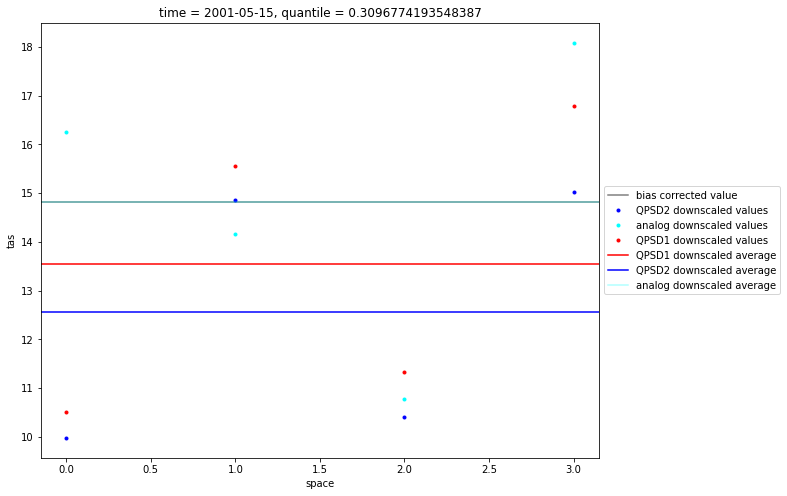

In [71]:
fig,ax = plt.subplots(1,1,figsize=(10,8))
ax.axhline(csim.isel(time=onetime), color='black', alpha=0.5, label="bias corrected value")

plt.plot(0, fsim_oneday1, marker='.',linestyle='none', color='blue')
plt.plot(1, fsim_oneday2, marker='.',linestyle='none', color='blue')
plt.plot(2, fsim_oneday3, marker='.',linestyle='none', color='blue')
plt.plot(3, fsim_oneday4, marker='.',linestyle='none', color='blue', label="QPSD2 downscaled values")

ana_color = 'cyan'
plt.plot(0, fsim_oneday11, marker='.',linestyle='none', color=ana_color)
plt.plot(1, fsim_oneday22, marker='.',linestyle='none', color=ana_color)
plt.plot(2, fsim_oneday33, marker='.',linestyle='none', color=ana_color)
plt.plot(3, fsim_oneday44, marker='.',linestyle='none', color=ana_color, label="analog downscaled values")

fsim_avg = (fsim_oneday1 + fsim_oneday2 + fsim_oneday3 + fsim_oneday4) / 4
fsim_avg_analog = (fsim_oneday11 + fsim_oneday22 + fsim_oneday33 + fsim_oneday44) / 4

fsim_oneday.plot(ax=ax, marker='.',linestyle='none', color='red', label="QPSD1 downscaled values")
ax.axhline(fsim_oneday.mean(), color='red', label="QPSD1 downscaled average")

ax.axhline(fsim_avg, color='blue', label="QPSD2 downscaled average")
ax.axhline(fsim_avg_analog, alpha=0.3, color=ana_color, label="analog downscaled average")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
print('analog downscaled average for this day: {}'.format(fsim_avg_analog.values))
print('bias corrected average for this day: {}'.format(csim.isel(time=onetime).values))

look at all adjustment factors in one figure 

Text(0.5, 1.0, 'analog adjustment factors')

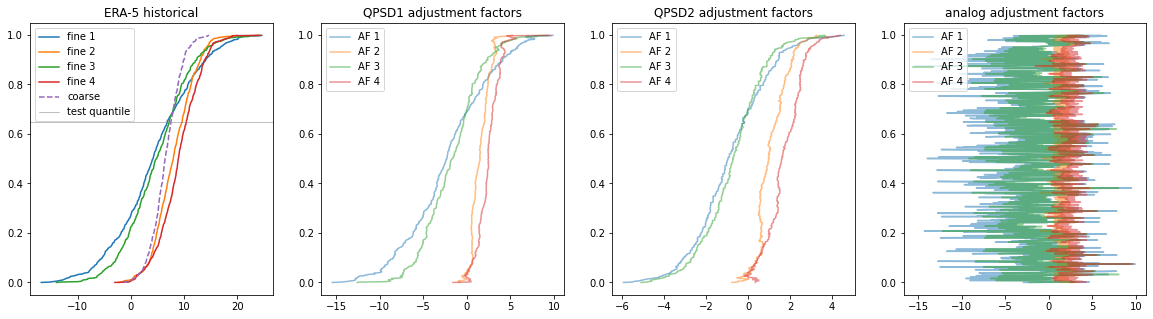

In [81]:
fig, axs = plt.subplots(1,4, figsize=(20, 5))
ax=axs[0]
# plot empirical cdfs
#   loop through space cells
dadt = []
for spi in [0,1,2,3]:
    x = np.sort(fine.sel(space=spi))
    y = np.arange(len(x))/float(len(x))
    _ = ax.plot(x, y, label="fine {}".format(spi+1))

    dadt.append(xr.DataArray([x,y],dims=('variable','cdf'), coords={'variable':['x','y']}))

finecdf = xr.concat(dadt, dim=fine.space)    

x = np.sort(coarse)
y = np.arange(len(x))/float(len(x))
_ = ax.plot(x, y, linestyle="--", label="coarse")
ax.axhline(y=testq, linewidth=.5, color='.5', label='test quantile')
ax.legend()
ax.set_title('ERA-5 historical')
# ax.set_xlim([-25, 25])

ax=axs[1]
for spi in [0,1,2,3]:
    xf = np.sort(fine.sel(space=spi))
    yf = np.arange(len(xf))/float(len(xf))
    
    xc = np.sort(coarse)
    yc = np.arange(len(xc))/float(len(xc))

    _ = ax.plot(xf-xc, yc, label="AF {}".format(spi+1), alpha=.5)

ax.legend()
ax.set_title('QPSD1 adjustment factors')

ax=axs[2]
for spi in [0,1,2,3]:
    xf = np.sort(fine.sel(space=spi))
    yf = np.arange(len(xf))/float(len(xf))
    
    xc = np.sort(coarse)
    yc = np.arange(len(xc))/float(len(xc))
    
    tau_of_inds = compute_tau_of(xc, xf)
    xc_tauof = xc[tau_of_inds]
    xf_tauof = xf[tau_of_inds]

    _ = ax.plot(xf_tauof - xc_tauof, yc, label="AF {}".format(spi+1), alpha=.5)

ax.legend()
ax.set_title('QPSD2 adjustment factors')

ax=axs[3]
day_inds = compute_day_ind(yc, coarse)
for spi in [0,1,2,3]:
    xf = np.sort(fine.sel(space=spi))
    yf = np.arange(len(xf))/float(len(xf))
    
    xc = np.sort(coarse)
    yc = np.arange(len(xc))/float(len(xc))
    
    xc_days = xc[day_inds]
    xf_days = xf[day_inds]

    _ = ax.plot(xf_days - xc_days, yc, label="AF {}".format(spi+1), alpha=.5)

ax.legend()
ax.set_title('analog adjustment factors')